# Sistemas Inteligentes: Aprendizaje Automático

_Guillermo Facundo Colunga_

## Introducción

Esta práctica de aprendizaje automático se enmarca en explorar los distintos paradigmas de clasificación estudiados en la asignatura para seleccionar aquel que mejor prediga el tipo de cancer según la información de expresión de los genes de distintas muestras de pacientes reales.

Para ello se evaluarán los paradigmas de clasificación **árbol de decisión, vecinos más cercanos, redes neuronales y máquinas de vector soporte** a través del paquete `caret` de R. 

Finalmente se realizará la comparación de los resultados aportados por los diferentes paradigmas y se seleccionará aquel que mejor precisión tenga como _el mejor_.


Empezamos configurando R e importanto el paquete `caret`. De la misma forma cargamos las librerías necesarias que vamos a utilizar durante el desarrollo de la práctica.

In [1]:
# Eliminamos los warnings del script ya que ensucian el script
options(warn=-1)

# Realizamos los imports necesarios
library(caret)
library(mlbench)
library(ggplot2)
library(gridExtra)
library(reshape2)

Loading required package: lattice
Loading required package: ggplot2


## Carga de datos en R

Una vez tenemos R configurado y con las librerías necesarias cargadas, importamos los datos sobre los que vamos a dearrollar nuestros modelos. Para ello descargamos en el directorio `/data` el siguiente banco de [datos](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq).

In [2]:
geneLevel <- read.csv('./data/data.csv',stringsAsFactors = F)
label <- read.csv('./data/labels.csv',stringsAsFactors = F)
tcga <- merge(geneLevel, label, sort = F)
tcga$X <- NULL

El banco de datos `tcga` contiene 20531 variables y 801 instancias. Para manejar tal cantidad de columnas en algunos casos haría falta una cantidad de memoria superior a la de un ordenador típico. Por esto solamente vamos a usar 100 variables que serán elegidas aletaroiamente según nuestro identificador universitario. De esta forma obtendremos un banco de datos de 100 variables y 801 instancias.

In [3]:
set.seed(236856) #Pon aquí los número de tu UO
tcga.filtered <- tcga[,c(sample(ncol(tcga)-1,100),ncol(tcga))]

# Mostramos los datos con los que trabajaremos.
head(tcga.filtered)

gene_12382,gene_8057,gene_3787,gene_2160,gene_8570,gene_4382,gene_17560,gene_14235,gene_13011,gene_15132,⋯,gene_2156,gene_9361,gene_17324,gene_20408,gene_12380,gene_14946,gene_14994,gene_8981,gene_17533,Class
0,9.223816,9.934118,7.416983,5.634797,4.827128,0.5918709,0,4.511449,6.559441,⋯,4.355777,0.0000000,0.0000000,6.075477,0.5918709,13.27560,8.869082,9.359207,2.824951,PRAD
0,8.648091,9.699633,8.499599,1.590818,7.388103,1.0043935,0,2.006585,7.346319,⋯,5.384385,0.0000000,0.3236583,5.803031,0.0000000,13.52978,8.978141,5.835166,5.608505,LUAD
0,9.183333,9.728832,8.250957,5.376231,3.976345,0.4525954,0,2.228018,6.640336,⋯,6.862092,0.0000000,0.0000000,5.983573,0.0000000,13.30788,8.412574,10.781515,3.796733,PRAD
0,9.130174,9.352198,8.414393,4.933119,6.128269,0.0000000,0,3.573556,6.355998,⋯,6.292150,0.0000000,0.4348817,7.023555,0.0000000,13.03412,8.979462,13.573434,2.478532,PRAD
0,9.070676,9.687939,8.798692,2.801097,6.065038,4.9603681,0,6.034081,7.276832,⋯,5.502560,0.6493855,0.0000000,5.861429,0.0000000,13.80710,9.804430,11.136728,4.304657,BRCA
0,8.648077,9.610272,9.036885,4.149373,4.853447,1.6538855,0,7.057948,6.734303,⋯,5.400569,2.1489341,0.0000000,5.355133,0.0000000,13.35543,8.258712,10.392393,4.149373,PRAD


Como vemos en la tabla anterior cada columna se collesponde con la información de expresión de un gen y la última columna identifica el tipo de cáncer.

Observando los datos en formato de tabla es muy complicado sacar cualquier conclusión preliminar sobre nuestros datos, por eso los exploraremos por médio de gráficas (para mejorar la resolución de las gráficas seleccionaremos únicamente los últimos 4 genes).

Using Class as id variables


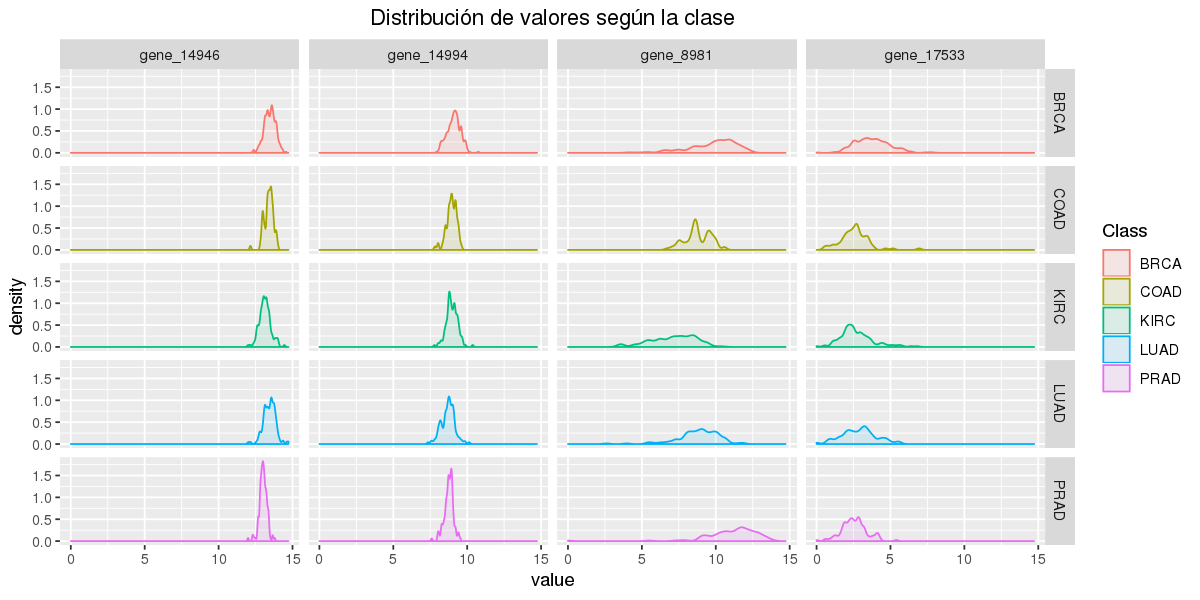

In [4]:
# Tamaño de las gráficas.
options(repr.plot.width=10, repr.plot.height=5)

ggplot(melt(tcga.filtered[(length(tcga.filtered) - 4):length(tcga.filtered)]), aes(x=value,color=Class, fill = Class)) +
    geom_density(adjust = 1/2, alpha=0.1) +
    ggtitle("Distribución de valores según la clase") +
    theme(plot.title = element_text(hjust = 0.5)) + facet_grid(rows = Class~variable)

En la gráfica anterior vemos los valores de las variables de forma individuales, lo que nos puede dar una idea inicial del tipo de probelma que es y que modelo se ajustaría mejor, sin embargo lo que nos interesará será ver como se relacionan las variables entre ellas, ya que un modelo predictivo intenta combinar las variables y sus interacciones.

Para ello vamos a ver la relación entre la información de expresión de los 2 últimos genes y el tipo de cáncer al que pertenencen.

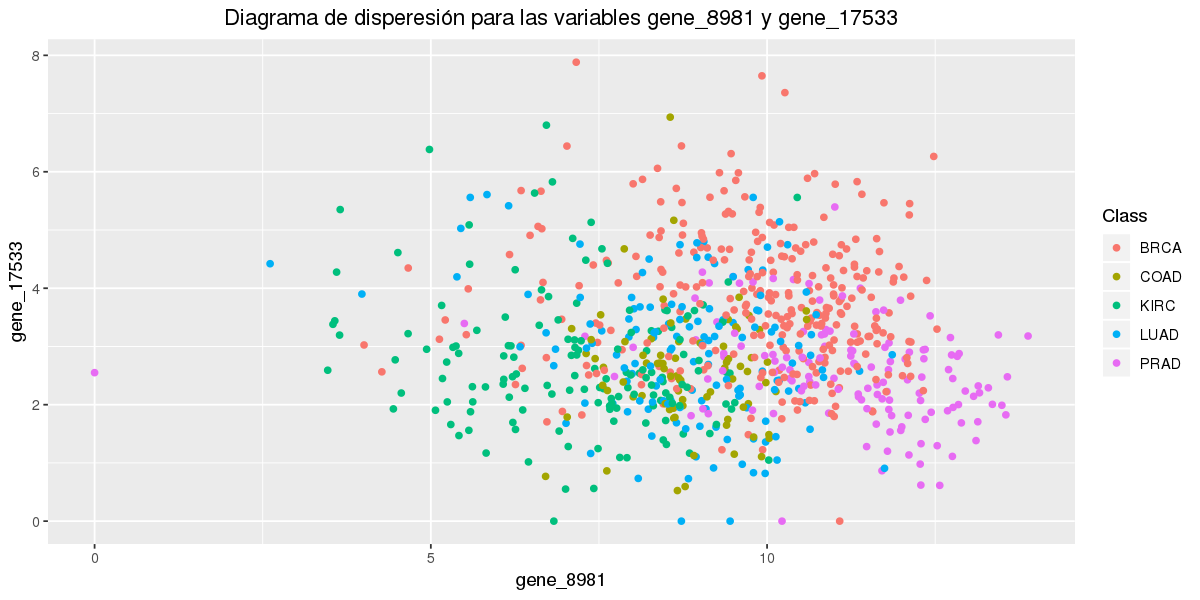

In [5]:
ggplot(tcga.filtered, aes(x=gene_8981,y=gene_17533,color=Class)) + 
    geom_point() + 
    ggtitle("Diagrama de disperesión para las variables gene_8981 y gene_17533") +
    theme(plot.title = element_text(hjust = 0.5))

Podríamos realizar la gráfica anterior 16 veces (1 para cada par de genes), sin embargo para verlo todo en un mismo bloque emplearemos una variante de la función makePairs vista en práctica

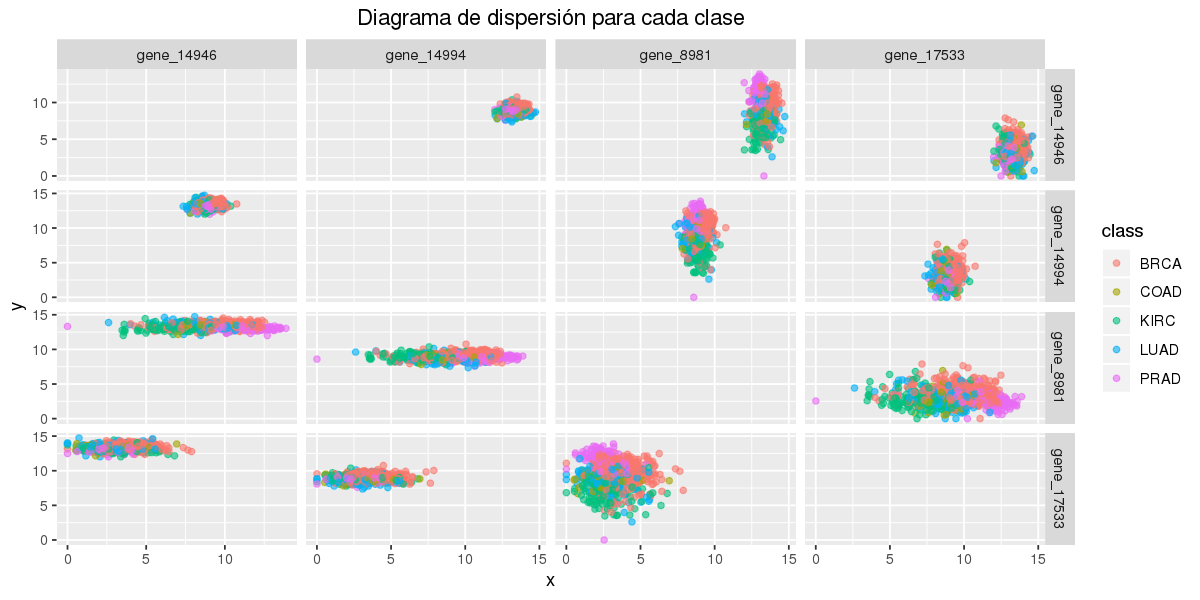

In [6]:
makePairs <- function(data,classIndex) { 
    dfm <- NULL
    for(i in 1:ncol(data)){
        if(i==classIndex)
          next
        for(j in 1:ncol(data)){ 
            if(j==classIndex)
                next
            if(i==j)
                next
            dfm <- rbind(dfm,data.frame(x=data[,i], y=data[,j], 
                                        Var1=colnames(data)[i], 
                                        Var2=colnames(data)[j],
                                        class=data[,classIndex]))
        }
    }
    dfm$Var2 <- relevel(dfm$Var2,levels(dfm$Var1)[1])
    dfm 
}
            
dataToPlot <- makePairs(tcga.filtered[(length(tcga.filtered) - 4):length(tcga.filtered)], 5)
ggplot(dataToPlot, aes_string(x = "x", y = "y")) + 
            facet_grid(Var1 ~ Var2, scales = "free") + 
            geom_point(aes(colour=class), alpha=0.6) + 
            ggtitle("Diagrama de dispersión para cada clase") +
            theme(plot.title = element_text(hjust = 0.5))

Evidentemente las conclusiones están limitadas por que sólo vemos relaciones en dos dimensiones, pero aún con esta limitación realizar esta tarea es importante para entender peculiaridades de los datos, detectar posibles problemas y contrastar lo que hemos podido inferir con lo que un modelo dice.

Una vez hemos entendido los datos sobre los que vamos a trabajar tenemos que realizar 2 particiones, una con la que entrenaremos nuestros modelos y otra con la que los validaremos. En este caso yaque tenemos 801 instancias y sólo 100 variables escogeremos un 75% de los datos para entrenamiento y un 25% para la validación.

In [7]:
inTrain <- createDataPartition(
    # indicamos la clase
    y = tcga.filtered$Class,
    
    # el porcentaje de instancias para entrenamiento
    p = .75,
    
    # controla el formato de salida
    list = FALSE
)

# Definimos nuestras particiones de entrenamiento y validación.
training <- tcga.filtered[ inTrain,]
testing <- tcga.filtered[-inTrain,]

## Esquemas de validación

Conocemos que existen distintos tipos de validación, cada uno con sus ventajas y desventajas. Sin embargo despues de probar con los diferentes esquemas para cada modelo se obtuvo que los siguientes son los que obtienen mejores resultados y por tanto serán los empleados para controlar la construcción de los modelos.

In [8]:
# Esquema de validación para árboles.
ctrlTrees <- trainControl(method="cv")

# Esquema de validación para vecinos más cercanos.
ctrlKnn <- trainControl(method="cv")

# Esquema de validación para redes neuronales. Bootstrap 10 reps.
ctrlNn <- trainControl(method = "boot632", number = 10)

# Esquema de validación para máquinas de vector soporte.
ctrlMvs <- trainControl(method="cv")

# Esquema de validación para máquinas de vector soporte.
ctrlMvsProbs <- trainControl(method="cv", classProbs = T)

## Árbol de decisión

De acuerdo con wikipedia, un árbol de decisión es un mecanismo en el que dado un conjunto de datos se fabrican diagramas de construcciones lógicas, muy similares a los sistemas de predicción basados en reglas, que sirven para representar y categorizar una serie de condiciones que ocurren de forma sucesiva, para la resolución de un problema. Por lo tanto, y teniendo en cuenta nuestros datos, parece un modelo que nos dará unos buenos resultados, sin embargo, vamos a contrastar esta hipótesis.

Tanto en teroría como en prácticas vimos distintos modelos de árboles de decisión, a continuación implementaremos los modelos J48, rpart y rpart2 para comparar su precisión para el problema dado.

In [9]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con J48.
c4.5Fit <- train(
    Class ~ .,
    data = training,
    method = "J48",
    trControl = ctrlTrees,
    # Empleamos C=0.04 y M=2 ya que son los valores que tras explorar
    # nos han dado mejor resultado y realizar siempre la exploración
    # de valores es demasiado lenta.
    tuneGrid = data.frame(C=0.04, M=2)
)

**A partir de este punto podemos emplear multriproceso para los entrenamientos. Para aprovechar al máximo los recursos del ordenador emplearemos el paquete `multicore`. Debemos de tener en cuenta que actualmente R sólo da soporte a múltiples núcleos en Linux, por lo tanto si se ejecuta desde otro S.O. es de esperar que no funcione, en ese caso se pueden eliminar las siguientes lineas y todo funcionará sin problemas en un solo core.**

In [10]:
library(doMC) 
registerDoMC(cores = 7) 

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [11]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con rpart.
rpartFit <- train(
    Class ~ .,
    data = training,
    method = "rpart",
    trControl = ctrlTrees,
    # Exploramos los resultados para 200 valores de cp crecientes desde 0.0.
    tuneLength = 200
)

In [12]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con rpart2.
rpart2Fit <- train(
    Class ~ .,
    data = training,
    method = "rpart2",
    trControl = ctrlTrees,
    # Exploramos los resultados hasta una profundidad de 8, que es la
    # profundidad máxima del arbol.
    tuneLength = 8
)

Para comparar los modelos de manera inicial emplearemos el sistema de matriz de confusión.

In [13]:
# Datos del modelo rpart2 y matriz de confusión para los datos de validación
c4.5Fit$results[rownames(c4.5Fit$bestTune),1:4]
confusionMatrix(predict(c4.5Fit,testing), factor(testing$Class))$overall[1:4]

# Datos del modelo rpart2 y matriz de confusión para los datos de validación
rpartFit$results[rownames(rpartFit$bestTune),1:4]
confusionMatrix(predict(rpartFit,testing), factor(testing$Class))$overall[1:4]

# Datos del modelo rpart2 y matriz de confusión para los datos de validación
rpart2Fit$results[rownames(rpart2Fit$bestTune),1:4]
confusionMatrix(predict(rpart2Fit,testing), factor(testing$Class))$overall[1:4]

C,M,Accuracy,Kappa
0.04,2,0.8417629,0.7893901


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9045226     0.8739835     0.8549181     0.9415330

,cp,Accuracy,Kappa,AccuracySD
12,0.01326926,0.8619992,0.8164838,0.03839539


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8542714     0.8069964     0.7974599     0.9001806

,maxdepth,Accuracy,Kappa,AccuracySD
5,8,0.8619992,0.8164838,0.03839539


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8542714     0.8069964     0.7974599     0.9001806

De los modelos datos anteriores podemos extraer direfentes conclusiones preliminares. Por ejemplo, tanto rpart como rpart2 obtiene una precisión mayor sobre los datos de entrenamiento que j48, sin embargo cuando realizamos la validación externa se puede observar que es precisamente j48 el que obtiene un resultado superior a rpart y rpart2. 

Sin embargo antes de realizar la conclusión de que j48 es el modelo más preciso debemos de realizar algunas comparaciones para ver si la mejora es significativa, o por la contra los resultados de los modelos son equivalentes. En este caso como rpart y rpart2 obtienen exactamente los mismos resultados tanto para datos de entrenamiento como para datos de validación realizar la comparación entre c4.5 y rpart será suficiente para extraer conclusiones de los 3 modelos.

In [14]:
# Test binomial entre c4.5(j48) y rpart 
binom.test(c(round(0.9045), round(1-0.9045))*nrow(testing), p = 0.8543)

# Test entre c4.5 y rpart de validación cruzada.
t.test(c4.5Fit$resample$Accuracy,rpartFit$resample$Accuracy,paired = T)


	Exact binomial test

data:  c(round(0.9045), round(1 - 0.9045)) * nrow(testing)
number of successes = 199, number of trials = 199, p-value = 3.537e-14
alternative hypothesis: true probability of success is not equal to 0.8543
95 percent confidence interval:
 0.9816337 1.0000000
sample estimates:
probability of success 
                     1 



	Paired t-test

data:  c4.5Fit$resample$Accuracy and rpartFit$resample$Accuracy
t = -0.90048, df = 9, p-value = 0.3913
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07107325  0.03060070
sample estimates:
mean of the differences 
            -0.02023628 


El test binomial nos indica que la diferencia en precisión entre c4.5 (j48), rpart y rpart2 es significativa y por lo tanto podemos decir que c4.5 obtiene una precisión significativamente mayor.

El segundo test nos indica que durante el entrenamiento las diferencias obtenidas entre c4.5, rpart y rpar2 no son significativas y por lo tanto, los modelos ajustan los datos de entrenamiento de forma similar pero c4.5 es capaz de generalizar mejor.

## Vecinos más cercanos

Otro de los paradigmas de clasificación vistos durante la asginatura es el de vecinos más cercanos o knn por sus siglas en inglés. Este paradigma no tiene un modelo, lo que hace es comparar el ejemplo con los datos a predecir y a través de distancias a k vecinos más cercanos precedir la clase.

Para iniciar nuestro modelo de vecinos más cercanos emplearemos 100 valores de k dados por la variable `tuneLength`. En principio tenemos 801 instancias del problema así que una k de 100 representaría 1/8 del mismo, sin embargo como veremos a continuación el valor ideal de k será mucho más bajo, ya que no es necesario emplear tantos puntos para predecir nuestro resultado.

In [15]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con rpart2.
knnFit <- train(
  Class ~ .,
  data = training,
  method = "knn",
  trControl = ctrlKnn,
  tuneLength = 100
)

In [16]:
knnFit$results[rownames(knnFit$bestTune),1:4]
confusionMatrix(predict(knnFit,testing), factor(testing$Class))$overall[1:4]

,k,Accuracy,Kappa,AccuracySD
2,7,0.9650652,0.9536216,0.01858812


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9698492     0.9601415     0.9355328     0.9888564

Como se explicaba previamente y con los resultados anteriores el valos de k que nos proporciona una precisión mayor sobre los datos de entrenamiento es 7, mucho más pequeña que la inicialmente dada, 100. Esto nos dice que comparando los datos a predecir con 7 vecinos más cercanos obtenemos una precisión de 96.98% sobre los datos de validación.

## Redes neuronales

Este es un método de clasificación no paramétrico, que estima el valor de la función de densidad de probabilidad o directamente la probabilidad a posteriori de que un elemento x pertenezca a la clase C a partir de la información proporcionada por el conjunto de prototipos. En el proceso de aprendizaje no se hace ninguna suposición acerca de la distribución de las variables predictoras.

Ahora pasamos a crear un primer modelo de red neuronal con una sola capa oculta. Para determinar el número de unidades ocultas pedimos a la función train que pruebe varios valores de 1 hasta 50 incrmenetando cada vez una unidad. Para estas redes se ha fijado el ratio de aprendizaje en 0.03 ya que es el que mejor resultados a aportado.

In [17]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn1LFit <- train(
    Class ~ .,
    data = training,
    method = "mlp",
    trControl = ctrlNn,
    learnFuncParams = c(0.03,0),
    tuneGrid = data.frame(size=seq(1,50,1))
)

Una vez entrenado nuestro modelo podemos ver los siguientes resultados respecto a los datos de entrenamiento y los datos de validación.

In [18]:
# Modelo de una única capa oculta.
nn1LFit$results[rownames(nn1LFit$bestTune),1:4]

# Matriz de confusión para el modelo de una única capa oculta.
confusionMatrix(predict(nn1LFit,testing), factor(testing$Class))$overall[1:4]

,size,Accuracy,Kappa,AccuracySD
47,47,0.9830305,0.9776,0.009865517


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9648241     0.9533302     0.9288700     0.9857426

Para el modelo anterior encontramos la precisión más elevada se da cuando empleamos 47 neuronas en la capa oculta, con un 98.3% sobre los datos de entrenamiento y un 96.48% sobre los datos de validación.

Vamos a probar con redes más profundas, pero limitando la complejidad (número de parámetros) a un nivel similar a la red anterior.

In [19]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn2LFit <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrlNn,
    learnFuncParams = c(0.03,0),
    tuneGrid = expand.grid(layer1=seq(25,27,1), layer2=seq(25,27,1), layer3=0)
)

Una vez entrenado nuestro modelo podemos ver los siguientes resultados respecto a los datos de entrenamiento y los datos de validación.

In [20]:
# Modelo de 2 capas ocultas.
nn2LFit$results[rownames(nn2LFit$bestTune),1:4]

# Matriz de confusión para el modelo de dos capas ocultas.
confusionMatrix(predict(nn2LFit,testing), factor(testing$Class))$overall[1:4]

,layer1,layer2,layer3,Accuracy
7,27,25,0,0.8393947


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9246231     0.9004735     0.8787246     0.9572001

Con los resultados anteriores podemos observar que para este problema una red neuronald de dos capas da una precisión mucho mayor que la de una única capa. Sin embargo vamos a explorar también el modelo construido con 3 capas ocultas para ver si una red aún más profunda favorece a la precisión.

In [21]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn3LFit <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrlNn,
    learnFuncParams = c(0.03,0),
    tuneGrid = expand.grid(layer1=seq(25,27,1), layer2=seq(25,27,1), layer3=seq(25,27,1))
)

Una vez entrenado nuestro modelo podemos ver los siguientes resultados respecto a los datos de entrenamiento y los datos de validación.

In [22]:
# Modelo de tres capas ocultas.
nn3LFit$results[rownames(nn3LFit$bestTune),1:4]

# Matriz de confusión para el modelo de tres capas ocultas.
confusionMatrix(predict(nn3LFit,testing), factor(testing$Class))$overall[1:4]

,layer1,layer2,layer3,Accuracy
24,27,26,27,0.7333865


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8643216     0.8154306     0.8087658     0.9086460

Parece que el modelo de 3 capas ocultas reduce la precisión sobre los datos de entrenamiento y de validación, por lo tanto, en una primera hipótesis el modelo de dos capas ocultas es el mejor para nuestro problema.

Para intentar entender estas diferencias vamos a inspeccionar como ha ido el proceso de aprendizaje de cada modelo.

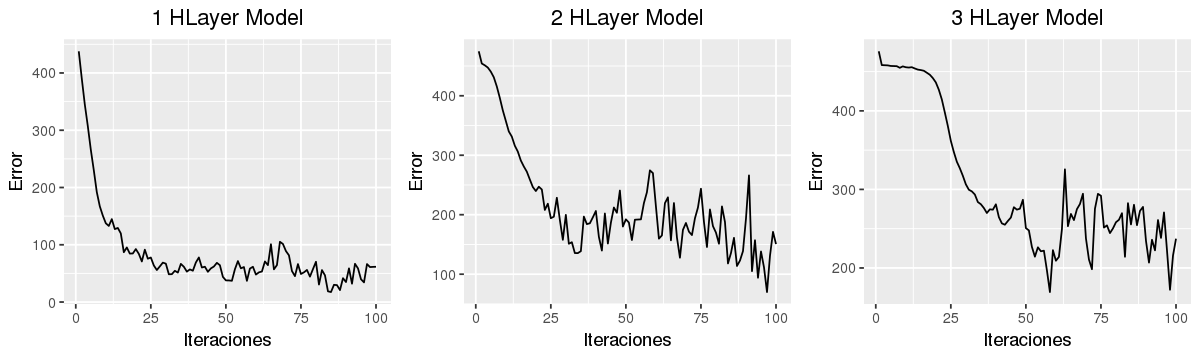

In [23]:
# Configuración del tamaño de las gráficas.
options(repr.plot.width=10, repr.plot.height=3)

errorNn1Err <- ggplot() + geom_line(aes(x=1:length(nn1LFit$finalModel$IterativeFitError), y=nn1LFit$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("1 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

errorNn2Err <- ggplot() + geom_line(aes(x=1:length(nn2LFit$finalModel$IterativeFitError), y=nn2LFit$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("2 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

errorNn3Err <- ggplot() + geom_line(aes(x=1:length(nn3LFit$finalModel$IterativeFitError), y=nn3LFit$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("3 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

grid.arrange(errorNn1Err, errorNn2Err, errorNn3Err, ncol=3)

De las curvas de aprendizaje anteriores podemos ver que en ninguna de ellas el error cometido alcanza un valor estable y está decreciendo en el momento de terminar las iteraciones (100 por defecto).

Pues ahora vamos a generar un modelo fijando el número de neuronas que daba el mejor resultado, pero aumentando el número de iteraciones. Previamente se ha comprovado que para valores mayores de 1000 el error permanece más o menos constante en todos los modelos, por tanto el valor `maxit` se corresponderá con el que mejor resultado de para los datos de validación. Así mismo también fijaremos el ratio de aprendizaje en 0.03 ya que es el que mejores resultados nos da.

In [24]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn1LFitOptimized <- train(
    Class ~ .,
    data = training,
    method = "mlp",
    trControl = ctrlNn,
    tuneGrid = data.frame(size=26),
    maxit = 1000,
    learnFuncParams = c(0.03,0)
)

In [25]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn2LFitOptimized <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrlNn,
    tuneGrid = expand.grid(layer1=27, layer2=25, layer3=0),
    maxit = 1000,
    learnFuncParams = c(0.03,0)
)

In [26]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn3LFitOptimized <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrlNn,
    tuneGrid = expand.grid(layer1=27, layer2=26, layer3=27),
    maxit = 1750,
    learnFuncParams = c(0.03,0)
)

Una vez realizado el entrenamiento de los tres modelos con el número de iteraciones fijado en 1000, 1000 y 1500 podemos volver a obtener los resultados con respecto a los datos de entrenamiento y validación.

In [27]:
# Modelo de una única capa oculta.
nn1LFitOptimized$results[rownames(nn1LFitOptimized$bestTune),1:4]

# Matriz de confusión para el modelo de una única capa oculta.
confusionMatrix(predict(nn1LFitOptimized,testing), factor(testing$Class))$overall[1:4]

# Modelo de 2 capas oculta con 5-7 neuronas.
nn2LFitOptimized$results[rownames(nn2LFitOptimized$bestTune),1:4]

# Matriz de confusión para el modelo de una única capa oculta y 7 neuronas.
confusionMatrix(predict(nn2LFitOptimized,testing), factor(testing$Class))$overall[1:4]

# Modelo de tres capas ocultas con 5-5-5 neuronas.
nn3LFitOptimized$results[rownames(nn3LFitOptimized$bestTune),1:4]

# Matriz de confusión para el modelo de una única capa oculta y 7 neuronas.
confusionMatrix(predict(nn3LFitOptimized,testing), factor(testing$Class))$overall[1:4]

size,Accuracy,Kappa,AccuracySD
26,0.982324,0.9767535,0.01659418


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9798995     0.9734605     0.9493370     0.9944968

layer1,layer2,layer3,Accuracy
27,25,0,0.9010665


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9447236     0.9275549     0.9032493     0.9720866

layer1,layer2,layer3,Accuracy
27,26,27,0.5878507


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8442211     0.7931046     0.7862307     0.8916355

Antes de aumentar el número de iteraciones el modelo de 2 capas ocultas era el mejor, sin embargo ahora obtenemos que el modelo de una única capa oculta nos da mejores resultados tanto en los datos de aprendizaje como en los de validación. Pero antes de realizar cualquier conclusión vamos a ver las curvas de apredizaje y realizar los tests binomiales y de t para ver si las diferencias son significativas.

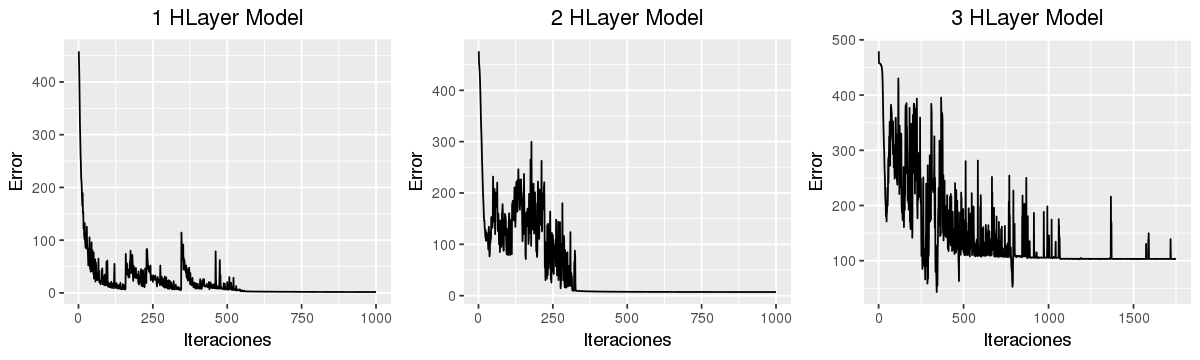

In [28]:
# Configuración del tamaño de las gráficas.
options(repr.plot.width=10, repr.plot.height=3)

errorNn1OptimizedErr <- ggplot() + geom_line(aes(x=1:length(nn1LFitOptimized$finalModel$IterativeFitError), y=nn1LFitOptimized$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("1 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

errorNn2OptimizedErr <- ggplot() + geom_line(aes(x=1:length(nn2LFitOptimized$finalModel$IterativeFitError), y=nn2LFitOptimized$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("2 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

errorNn3OptimizedErr <- ggplot() + geom_line(aes(x=1:length(nn3LFitOptimized$finalModel$IterativeFitError), y=nn3LFitOptimized$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("3 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

grid.arrange(errorNn1OptimizedErr, errorNn2OptimizedErr, errorNn3OptimizedErr, ncol=3)

In [29]:
# Test binomial entre c4.5(j48) y rpart 
binom.test(c(round(0.9799), round(1-0.9799))*nrow(testing), p = 0.9447)

# Test entre c4.5 y rpart de validación cruzada.
t.test(nn1LFitOptimized$resample$Accuracy, nn2LFitOptimized$resample$Accuracy,paired = T)


	Exact binomial test

data:  c(round(0.9799), round(1 - 0.9799)) * nrow(testing)
number of successes = 199, number of trials = 199, p-value = 2.88e-05
alternative hypothesis: true probability of success is not equal to 0.9447
95 percent confidence interval:
 0.9816337 1.0000000
sample estimates:
probability of success 
                     1 



	Paired t-test

data:  nn1LFitOptimized$resample$Accuracy and nn2LFitOptimized$resample$Accuracy
t = 3.174, df = 9, p-value = 0.01129
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.03442994 0.20526383
sample estimates:
mean of the differences 
              0.1198469 


El test binomial nos indica que el modelo de una única capa, optimizado en número de iteraciones, es significativamente más preciso que el modelo de 2 capas. Y el test de t nos dice que el entrenamiento del modelo de una única capa ha sido mejor.

## Máquinas vector soporte

Estos métodos están propiamente relacionados con problemas de clasificación y regresión. Dado un conjunto de ejemplos de entrenamiento (de muestras) podemos etiquetar las clases y entrenar una SVM para construir un modelo que prediga la clase de una nueva muestra. Intuitivamente, una SVM es un modelo que representa a los puntos de muestra en el espacio, separando las clases a 2 espacios lo más amplios posibles mediante un hiperplano de separación definido como el vector entre los 2 puntos, de las 2 clases, más cercanos al que se llama vector soporte. Cuando las nuevas muestras se ponen en correspondencia con dicho modelo, en función de los espacios a los que pertenezcan, pueden ser clasificadas a una o la otra clase.

De la misma forma que con los árboles de decisión para las máquinas de vector soporte encontramos diferentes tipos, Lineares, Polinomial y Radial

In [30]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

svmLinealFit <- train(
    Class ~ .,
    data = training,
    method = "svmLinear",
    trControl = ctrlMvs,
    tuneGrid = data.frame(C=1),
    scale = FALSE
)

In [31]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

svmPolyFit <- train(
    Class ~ .,
    data = training,
    method = "svmPoly",
    trControl = ctrlMvsProbs,
    tuneGrid = expand.grid(degree=c(2,3),C=c(1,5),scale = c(0.1, 0.5, 1))
)

In [32]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

svmRadialFit <- train(
    Class ~ .,
    data = training,
    method = "svmRadial",
    trControl = ctrlMvsProbs, 
    tuneGrid = expand.grid(sigma=c(1,3),C=c(1,5)) 
)

Con los modelos anteriores entrenamos podemos mostrar las precisiones respecto a los datos de entrenamiento y a los datos de validación

In [33]:
svmLinealFit$results[rownames(svmLinealFit$bestTune),1:4]
confusionMatrix(predict(svmLinealFit,testing),factor(testing$Class))$overall[1:2]

svmPolyFit$results[rownames(svmPolyFit$bestTune),1:5]
confusionMatrix(predict(svmPolyFit,testing),factor(testing$Class))$overall[1:2]

svmRadialFit$results[rownames(svmRadialFit$bestTune),1:4]
confusionMatrix(predict(svmRadialFit,testing),factor(testing$Class))$overall[1:2]

C,Accuracy,Kappa,AccuracySD
1,0.9799917,0.9735754,0.01331374


Accuracy     Kappa 
0.9698492 0.9602119

,degree,C,scale,Accuracy,Kappa
4,2,5,0.1,0.8238621,0.7595217


Accuracy     Kappa 
0.8291457 0.7679380

,sigma,C,Accuracy,Kappa
3,3,1,0.3737775,0


Accuracy     Kappa 
0.3768844 0.0000000

Para los resultados aportados por los modelos anteriores no es necesario realizar ningún test de validación ya que a simple vista se puede ver que el modelo lineal tiene una precisión muy superior al resto de modelos.

## Comparación de los paradigmas

Para realizar la comparación de los paradigmas explorados seleccionaremos sólo aquellos modelos que durante el desarrollo de la práctica identificamos como los _mejores_. Estos fueron: **C4.5** para árboles de decisión, **knn** para vecinos más cercanos, el modelo de **una única capa oculta optimizado en iteraciones** para las redes neuronales y finalmente el **modelo lineal** para las máquinas de vector soporte. Los resultados obtenidos para la validación externa de cada paradigma són los siguientes.

In [34]:
c4.5Fit.accuracy <- confusionMatrix(predict(c4.5Fit,testing), factor(testing$Class))$overall[1:1]
cat("C4.5 -", c4.5Fit.accuracy, "\n")

knnFit.accuracy <- confusionMatrix(predict(knnFit,testing), factor(testing$Class))$overall[1:1]
cat("knn -", knnFit.accuracy, "\n")

nn1LFitOptimized.accuracy <- confusionMatrix(predict(nn1LFitOptimized,testing), factor(testing$Class))$overall[1:1]
cat("nn1L -", nn1LFitOptimized.accuracy, "\n")

svmLinealFit.accuracy <- confusionMatrix(predict(svmLinealFit,testing), factor(testing$Class))$overall[1:1]
cat("svmLineal -", svmLinealFit.accuracy, "\n")

C4.5 - 0.9045226 
knn - 0.9748744 
nn1L - 0.9798995 
svmLineal - 0.9698492 


Ahora realizaremos las comparaciones con el test binomial entre el modelo que parece más preciso, knn y el resto de modelos.

In [35]:
# Test binomial entre knn y c4.5 
binom.test(c(round(knnFit.accuracy), round(1-knnFit.accuracy))*nrow(testing), p = c4.5Fit.accuracy)


	Exact binomial test

data:  c(round(knnFit.accuracy), round(1 - knnFit.accuracy)) * nrow(testing)
number of successes = 199, number of trials = 199, p-value = 3.671e-09
alternative hypothesis: true probability of success is not equal to 0.9045226
95 percent confidence interval:
 0.9816337 1.0000000
sample estimates:
probability of success 
                     1 


El test binomial entre el modelo knn y el modelo c4.5 nos dice que knn es significativamente más preciso para los datos de validación.

In [36]:
# Test binomial entre knn y nn1L 
binom.test(c(round(knnFit.accuracy), round(1-knnFit.accuracy))*nrow(testing), p = nn1LFitOptimized.accuracy)


	Exact binomial test

data:  c(round(knnFit.accuracy), round(1 - knnFit.accuracy)) * nrow(testing)
number of successes = 199, number of trials = 199, p-value = 0.03775
alternative hypothesis: true probability of success is not equal to 0.9798995
95 percent confidence interval:
 0.9816337 1.0000000
sample estimates:
probability of success 
                     1 


El test binomial entre el modelo knn y el modelo de una única capa oculta optimizado en iteraciones nos dice que knn es también más preciso para los datos de validación.

In [37]:
# Test binomial entre knn y svmLinealFit 
binom.test(c(round(knnFit.accuracy), round(1-knnFit.accuracy))*nrow(testing), p = svmLinealFit.accuracy)


	Exact binomial test

data:  c(round(knnFit.accuracy), round(1 - knnFit.accuracy)) * nrow(testing)
number of successes = 199, number of trials = 199, p-value = 0.005359
alternative hypothesis: true probability of success is not equal to 0.9698492
95 percent confidence interval:
 0.9816337 1.0000000
sample estimates:
probability of success 
                     1 


El test binomial entre el modelo knn y el modelo svmLineal nos dice que knn es significativamente más preciso para los datos de validación.

Ahora observemos una gráfica de comparación con los modelos más precisos de cada paradigma.

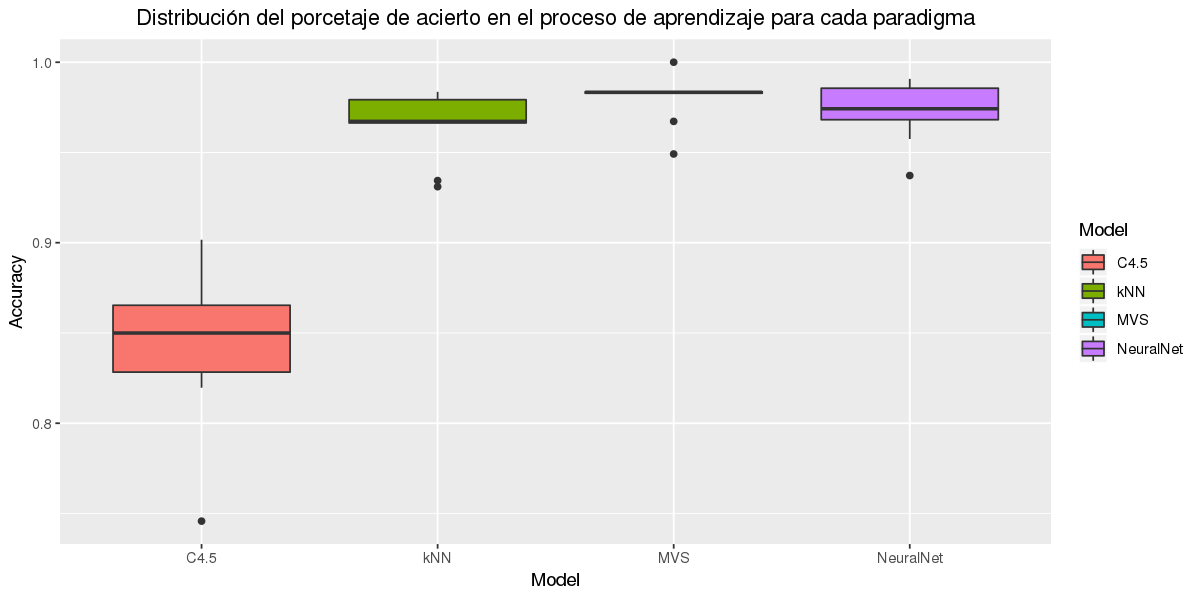

In [38]:
options(repr.plot.width=10, repr.plot.height=5)
dfm.resamp <- data.frame(Accuracy = c(nn1LFitOptimized$resample$Accuracy,
                                      c4.5Fit$resample$Accuracy,
                                      knnFit$resample$Accuracy,
                                      svmLinealFit$resample$Accuracy), 
                        Model = rep(c('NeuralNet','C4.5','kNN', 'MVS'), each=10))
ggplot(dfm.resamp,aes(x=Model, y=Accuracy, fill=Model)) + geom_boxplot() +
ggtitle("Distribución del porcetaje de acierto en el proceso de aprendizaje para cada paradigma") +
theme(plot.title = element_text(hjust = 0.5))

El modelo MVS con C=1 presenta un porcentaje de acierto muy alto basado en el muestreo bootstrap, ligeramente superior a los modelos de redes neuronales y kNN. La gráfica anterior muestra la distribución de los 10 valores de bootstrap para cada paradigma. Aunque el modelo de árbol de decisión c4.5 no es el que presenta el mayor valor de acierto si es el más estable.